# Energy market predictions

In [ ]:
import pandas as pd # biblioteka do działań na danych w postaci tabelarycznej
import matplotlib.pyplot as plt
import seaborn as sns # druga biblioteka do wykresów
import tensorflow as tf
import calendar
import keras
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import numpy as np
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error
from math import sqrt
from os.path import exists

Loading data

In [ ]:
train_data = pd.read_csv('../content/rdn_train.csv', sep=',')
test_data = pd.read_csv('../content/rdn_test.csv', sep=',')

Date formatting and adding 'day of week' entry

In [ ]:
# formatowanie dat
train_data['date_hour'] = train_data['date'] + ' ' + train_data['hour'].astype(str).str.pad(width=2, fillchar='0')
test_data['date_hour'] = test_data['date'] + ' ' + test_data['hour'].astype(str).str.pad(width=2, fillchar='0')
train_data['date_hour'] = pd.to_datetime(train_data['date_hour'], format="%Y-%m-%d %H")
train_data.set_index('date_hour', inplace=True)
train_data['month'] = pd.to_numeric(train_data['date'].astype(str).str.slice(5,7))
test_data['month'] = pd.to_numeric(test_data['date'].astype(str).str.slice(5,7))
train_data['year'] = pd.to_numeric(train_data['date'].astype(str).str.slice(0,4))
test_data['year'] = pd.to_numeric(test_data['date'].astype(str).str.slice(0,4))

#Dodanie kolumny z dniem tygodnia
arr = []
for x in train_data.index:
 arr.append(
    calendar.weekday(
        int(str(x)[0:4]),
        int(str(x)[5:7]),
        int(str(x)[8:10])
    ) + 1
 )
train_data['dow'] = arr

arr = []
for x in test_data['date']:
 arr.append(
    calendar.weekday(
        int(str(x)[0:4]),
        int(str(x)[5:7]),
        int(str(x)[8:10])
    ) + 1
 )
test_data['dow'] = arr

Functions for acquiring data from custom hours (proved to be unuseful)

In [ ]:
#def add_hour_columns (hour,data):
#    hour = np.sort(hour)
#    for i in range(0,len(hour)):
#        minus_hour = [0] * hour[i]
#        for j in range(hour[i],len(data)):
#            minus_hour.append(data['fixing_minus_1d'][j-hour[i]])
#        data[('fixing_minus_1d_'+str(hour[i])+'h')] = minus_hour
#    data = data.iloc[hour[-1]:]
#    return data
#train_data = add_hour_columns([4,8,12,16,20],train_data)
#test_data = add_hour_columns([4,8,12,16,20],test_data)

Defining sets

In [ ]:
train_data.columns

Index(['fixing', 'fixing_1_volume', 'hour', 'date',
       'Krajowe zapotrzebowanie na moc', 'Suma zdolności wytwórczych JWCD',
       'Suma zdolności wytwórczych nJWCD', 'Generacja JWCD', 'Generacja nJWCD',
       'Generacja źródeł wiatrowych',
       'Wymagana rezerwa mocy ponad zapotrzebowanie', 'fixing_minus_1d',
       'fixing_minus_2d', 'fixing_minus_3d', 'fixing_minus_4d',
       'fixing_minus_5d', 'fixing_minus_6d', 'fixing_minus_7d',
       'fixing_1_volume_minus_1d', 'month', 'year', 'dow'],
      dtype='object')

In [ ]:
cols = ['hour', 'Krajowe zapotrzebowanie na moc', 'Suma zdolności wytwórczych JWCD',
       'Suma zdolności wytwórczych nJWCD', 'Generacja JWCD', 'Generacja nJWCD',
       'Generacja źródeł wiatrowych',
       'Wymagana rezerwa mocy ponad zapotrzebowanie', 'fixing_minus_1d',
       'fixing_minus_2d', 'fixing_minus_3d', 'fixing_minus_4d',
       'fixing_minus_5d', 'fixing_minus_6d', 'fixing_minus_7d',
       'fixing_1_volume_minus_1d', 'month', 'year', 'dow']

In [ ]:
y = train_data['fixing']
X = train_data[cols]
X_test = test_data[cols]

Checking which data entries affect output to what degree

In [ ]:
res = sm.OLS(y,X)
res = res.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 fixing   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     1635.
Date:                Mon, 29 Nov 2021   Prob (F-statistic):               0.00
Time:                        21:53:32   Log-Likelihood:                -43633.
No. Observations:                8760   AIC:                         8.730e+04
Df Residuals:                    8742   BIC:                         8.743e+04
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
===============================================================================================================
                                                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------
hour                                           -0.7731      0.064    -12.041      0.000      -0.899      -0.647
Krajowe zapotrzebowanie na moc                  0.0272      0.005      6.005      0.000       0.018       0.036
Suma zdolności wytwórczych JWCD                -0.0063      0.000    -13.948      0.000      -0.007      -0.005
Suma zdolności wytwórczych nJWCD               -0.0116      0.002     -4.770      0.000      -0.016      -0.007
Generacja JWCD                                  0.0136      0.002      5.864      0.000       0.009       0.018
Generacja nJWCD                                 0.0136      0.003      4.864      0.000       0.008       0.019
Generacja źródeł wiatrowych                    -0.0079      0.001    -11.938      0.000      -0.009      -0.007
Wymagana rezerwa mocy ponad zapotrzebowanie    -0.3224      0.074     -4.385      0.000      -0.466      -0.178
fixing_minus_1d                                 0.1902      0.009     22.176      0.000       0.173       0.207
fixing_minus_2d                                 0.0263      0.009      3.026      0.002       0.009       0.043
fixing_minus_3d                                 0.0614      0.008      7.253      0.000       0.045       0.078
fixing_minus_4d                                 0.0382      0.008      4.525      0.000       0.022       0.055
fixing_minus_5d                                -0.0088      0.008     -1.046      0.295      -0.025       0.008
fixing_minus_6d                                -0.0141      0.009     -1.656      0.098      -0.031       0.003
fixing_minus_7d                                 0.1082      0.009     12.451      0.000       0.091       0.125
fixing_1_volume_minus_1d                        0.0049      0.001      5.721      0.000       0.003       0.007
month                                           4.1416      0.143     28.999      0.000       3.862       4.422
year                                            0.0535      0.006      9.617      0.000       0.043       0.064
dow                                            -2.9293      0.239    -12.282      0.000      -3.397      -2.462
==============================================================================
Omnibus:                     8055.747   Durbin-Watson:                   0.314
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           523349.250
Skew:                           4.235   Prob(JB):                         0.00
Kurtosis:                      39.907   Cond. No.                     1.85e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.93e-20. T

Choosing the best model

In [ ]:
if exists('../my_best_model.hdf5'):
  ;
else:
  checkpoint = ModelCheckpoint(filepath = '../my_best_model.hdf5',
                              monitor='val_root_mean_squared_error',
                              verbose=1, 
                              save_best_only=True,
                              mode=min)
  callbacks = [checkpoint]
  for i in range(15,25):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(i, activation="LeakyReLU", input_shape=(19,)),
        tf.keras.layers.Dense(1, activation="linear")
        ])
    model.compile(optimizer='adam', loss='mean_squared_error', 
                  metrics = [tf.keras.metrics.RootMeanSquaredError(),
                              'mean_absolute_error'])
    model.fit(X, y,epochs=30,callbacks=callbacks, validation_split=0.3)

  for i in range(15,25):
    for j in range(10,20):
      model = tf.keras.Sequential([
          tf.keras.layers.Dense(i, activation="LeakyReLU", input_shape=(19,)),
          tf.keras.layers.Dense(j, activation="LeakyReLU"),
          tf.keras.layers.Dense(1, activation="linear")
          ])
      model.compile(optimizer='adam', loss='mean_squared_error', 
                    metrics = [tf.keras.metrics.RootMeanSquaredError(),
                                'mean_absolute_error'])
      model.fit(X, y,epochs=30,callbacks=callbacks, validation_split=0.3)

Loading the best model

In [ ]:

best_model = keras.models.load_model('../my_best_model.hdf5')

Making predictions

In [ ]:
y_hat = best_model.predict(X_test)

In [ ]:
# zapis wyniku dopliku csv
result = pd.DataFrame(y_hat, columns=['fixing'])
result.to_csv('.//submission.csv', sep=',', index_label='nr')

In [ ]:
y_hat_train = best_model.predict(X)
df_plot = pd.DataFrame(y)
df_plot['y_hat'] = y_hat_train
# wybór zakresu dat
df_plot = df_plot[df_plot.index < '02-01-2018']

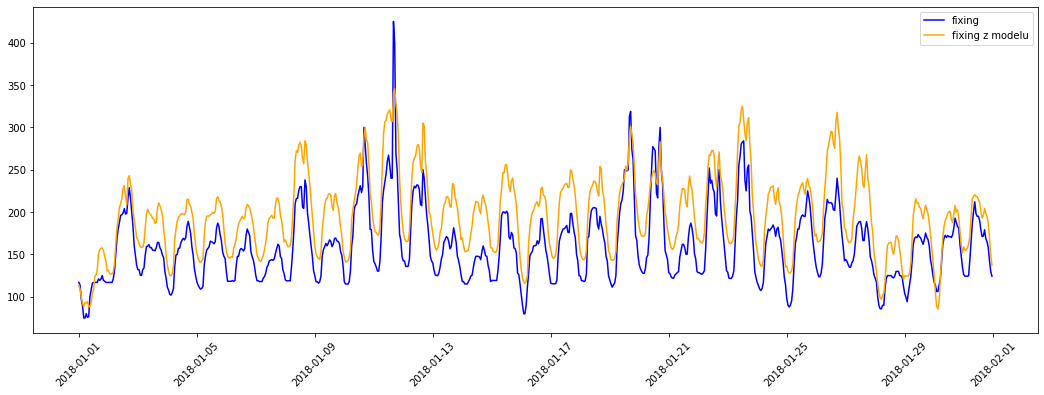

In [ ]:
plt.figure(figsize=(18, 6))
plt.plot(df_plot['fixing'], 'blue')
plt.plot(df_plot['y_hat'], 'orange')
plt.xticks(rotation=45);
plt.legend(['fixing', 'fixing z modelu'])

Checking how well our model will do on test data

In [ ]:
y_hat_list = y_hat.flatten().tolist()
test_fixings = []
for i in range(24, len(test_data)):
  test_fixings.append(test_data['fixing_minus_1d'][i])
for i in range(0, 24):
  test_fixings.append(test_fixings[-i])
rmse = sqrt(mean_squared_error(y_hat_list, test_fixings))
rmse

21.77377955734534